# Workflow


1. Creating corpus using Sketch Engine
2. Creating word embedding using Genism , Word2Vec
3. Preprocessing 
4. Removing common words that are not required
5. Creating phrases of words that frequently occur togther (bigrams)
6. Building word2vec model
7. Extracting resumes (using PyPDF) and converting to string
8. Building candidate profile using model.most_similar(skills), where skills is an array of required skills
9. Creating a matcher using Spacy to match the wods in resume to most_similar(skills)
12. Printing and visualizing the candidate profile

### Creating Corpus using sketch Engine

We used SketchEngine to create a corpus, wikipedia pages were given as input 


### Creating word embedding 

In [1]:
from gensim.models import Word2Vec
import string
import re
import nltk
from nltk.corpus import stopwords
import PyPDF2
import os
import collections
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher
import collections
import docx2txt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from tika import parser
from nltk.tokenize import word_tokenize
import gensim
from gensim.models.phrases import Phraser, Phrases
cv = CountVectorizer()
nltk.download('stopwords')
with open(r'C:\Users\Adarsh\Documents\ML\resume-scoring\skills.txt',encoding="utf8") as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adarsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
content[1]

'Data science is a "concept to unify statistics, data analysis, machine learning and their related methods" in order to "understand and analyze actual phenomena" with data. It employs techniques and theories drawn from many fields within the context of mathematics, statistics, information science, and computer science. Turing award winner Jim Gray imagined data science as a "fourth paradigm" of science (empirical, theoretical, computational and now data-driven) and asserted that "everything about science is changing because of the impact of information technology" and the data deluge.'

**Preprocessing**

In [3]:
x=[]
for line in content:
    tokens=word_tokenize(line)
    tok=[w.lower() for w in tokens]
    table=str.maketrans('','',string.punctuation)
    strpp=[w.translate(table) for w in tok]
    words=[word for word in strpp if word.isalpha()]
    stop_words=set(stopwords.words('english'))
    words=[w for w in words if not w in stop_words]
    x.append(words)

In [4]:
texts=x
print(texts[6])

['william', 'cleveland', 'introduced', 'data', 'science', 'independent', 'discipline', 'extending', 'field', 'statistics', 'incorporate', 'advances', 'computing', 'data', 'article', 'data', 'science', 'action', 'plan', 'expanding', 'technical', 'areas', 'field', 'statistics', 'published', 'volume', 'april', 'edition', 'international', 'statistical', 'review', 'revue', 'internationale', 'de', 'statistique', 'report', 'cleveland', 'establishes', 'six', 'technical', 'areas', 'believed', 'encompass', 'field', 'data', 'science', 'multidisciplinary', 'investigations', 'models', 'methods', 'data', 'computing', 'data', 'pedagogy', 'tool', 'evaluation', 'theory']


**Removing commonly occuring words that are not useful**

In [5]:
with open('common.txt') as f:
    content2 = f.read()
ntexts=[]
l=len(texts)
for j in range(l):
    s=texts[j]
    res = [i for i in s if i not in content2]
    ntexts.append(res)
print(texts[6], len(texts[6]))

    

['william', 'cleveland', 'introduced', 'data', 'science', 'independent', 'discipline', 'extending', 'field', 'statistics', 'incorporate', 'advances', 'computing', 'data', 'article', 'data', 'science', 'action', 'plan', 'expanding', 'technical', 'areas', 'field', 'statistics', 'published', 'volume', 'april', 'edition', 'international', 'statistical', 'review', 'revue', 'internationale', 'de', 'statistique', 'report', 'cleveland', 'establishes', 'six', 'technical', 'areas', 'believed', 'encompass', 'field', 'data', 'science', 'multidisciplinary', 'investigations', 'models', 'methods', 'data', 'computing', 'data', 'pedagogy', 'tool', 'evaluation', 'theory'] 57


In [6]:
print(ntexts[6], len(ntexts[6]))

['william', 'cleveland', 'introduced', 'science', 'independent', 'discipline', 'extending', 'incorporate', 'advances', 'computing', 'article', 'science', 'plan', 'expanding', 'technical', 'areas', 'published', 'volume', 'april', 'edition', 'international', 'statistical', 'revue', 'internationale', 'statistique', 'cleveland', 'establishes', 'six', 'technical', 'areas', 'believed', 'encompass', 'science', 'multidisciplinary', 'investigations', 'models', 'methods', 'computing', 'pedagogy', 'evaluation', 'theory'] 41


In [7]:
texts=ntexts
content=texts

**Creating bigrams**

In [8]:
common_terms = ["of", "with", "without", "and", "or", "the", "a"]
x=ntexts
# Create the relevant phrases from the list of sentences:
phrases = Phrases(x, common_terms=common_terms)
# The Phraser object is used from now on to transform sentences
bigram = Phraser(phrases)
# Applying the Phraser to transform our sentences
all_sentences = list(bigram[x])
model=gensim.models.Word2Vec(all_sentences,size=5000,min_count=2,workers=4,window=4)
model.save("final.model")
wrds=list(model.wv.vocab)

print(len(wrds))

1043


**Testing**

In [9]:
z=model.wv.most_similar("machine_learning")
print(z)

[('using', 0.13716059923171997), ('may', 0.12232674658298492), ('language', 0.11214740574359894), ('science', 0.10716243833303452), ('used', 0.1022757962346077), ('systems', 0.09840525686740875), ('many', 0.09753473848104477), ('deep_learning', 0.09652617573738098), ('computer', 0.09038585424423218), ('developed', 0.08755450695753098)]


### Resume Parsing

**Reading Resumes and Job Description from folder**

In [10]:
mypath=r'C:\Users\Adarsh\Documents\ML\resume-scoring\Resumes'
#Path for the files
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
job_description = docx2txt.process("C:\\Users\\Adarsh\\Documents\\ML\\resume-scoring\\job_description.docx")

**Function to words from resume**

In [11]:
def pdfextract(file):
    pdf_file = open(file, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))
    for i in c:
        #page
        page = read_pdf.getPage(i)
        page_content = page.extractText()
    return (page_content.encode('utf-8'))

In [12]:
sim_words=[k[0] for k in model.wv.most_similar("machine_learning")]

In [13]:
def create_bigram(words):
    common_terms = ["of", "with", "without", "and", "or", "the", "a"]
    x=words.split()
# Create the relevant phrases from the list of sentences:
    phrases = Phrases(x, common_terms=common_terms)
# The Phraser object is used from now on to transform sentences
    bigram = Phraser(phrases)
# Applying the Phraser to transform our sentences is simply
    all_sentences = list(bigram[x])
    
    

**Function to build candidate profile**

In [14]:
def create_profile(file):
    model=Word2Vec.load("final.model")
    text = str(pdfextract(file))
    text = text.replace("\\n", "")
    text = text.lower()
    #print(text)
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dictionary = pd.read_csv(r'C:\Users\Adarsh\Documents\ML\resume-scoring\technical_skills.csv')
    ML = [nlp(text[0]) for text in model.wv.most_similar("machine_learning")]
    DL = [nlp(text[0]) for text in model.wv.most_similar("deep")]
    Prmng = [nlp(text[0]) for text in model.wv.most_similar("programming")]
    print("*******************************************")
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('ML', None, *ML)
    matcher.add('DL', None, *DL)
    matcher.add('Prgm', None, *Prmng)
    doc = nlp(text)
    
    d = []  
    
    matches = matcher(doc)
    
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode I
        span = doc[start : end]               # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    print("KEYWORDS")
    print(keywords)
    print('\n')
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    print("********************Data Frame********************")
    print(df)
    print('\n')
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
    
       
    name = filename.split('_')
    print(name)
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)
    print("******************DATA FRAME**************")
    print(dataf)
    print('\n')
    return(dataf)

**Code to execute the above functions**

In [15]:
#Code to execute the above functions 
final_db=pd.DataFrame()
i=0
while i < len(onlyfiles):
    file=onlyfiles[i]
    dat=create_profile(file)

    final_db=final_db.append(dat)
    i+=1
    #print(final_db)

*******************************************
KEYWORDS
Prgm training (1)
DL learning (2)
Prgm using (1)
ML using (1)
DL using (1)
Prgm used (3)
ML used (3)
DL used (3)
Prgm also (1)
DL also (1)
ML developed (2)
ML computer (1)
Prgm science (1)
ML science (1)
DL science (1)


********************Data Frame********************
        Keywords_List
0   Prgm training (1)
1     DL learning (2)
2      Prgm using (1)
3        ML using (1)
4        DL using (1)
5       Prgm used (3)
6         ML used (3)
7         DL used (3)
8       Prgm also (1)
9         DL also (1)
10   ML developed (2)
11    ML computer (1)
12   Prgm science (1)
13     ML science (1)
14     DL science (1)


['Adarsh']
******************DATA FRAME**************
   Candidate Name Subject     Keyword Count
0          adarsh    Prgm   training      1
1          adarsh      DL   learning      2
2          adarsh    Prgm      using      1
3          adarsh      ML      using      1
4          adarsh      DL      using      1
5  

**Counting words under each category and building the candidate profile**

In [16]:
#Code to count words under each category and visualize it through MAtplotlib
final_db2 = final_db['Keyword'].groupby([final_db['Candidate Name'], final_db['Subject']]).count().unstack()
final_db2.reset_index(inplace = True)
final_db2.fillna(0,inplace=True)
candidate_data = final_db2.iloc[:,1:]
candidate_data.index = final_db2['Candidate Name']
#the candidate profile in a csv format
cand=candidate_data.to_csv('candidate_profile.csv')
cand_profile=pd.read_csv('candidate_profile.csv')
#cand_profile
print(cand_profile)

   Candidate Name  DL  ML  Prgm
0          adarsh   5   5     5
1   chandler bing   1   1     1
2      maria lisa   1   1     1
3  meghna lohani    2   1     2
4   phoebe buffay   2   1     1


**Visualizing by matplotlib**

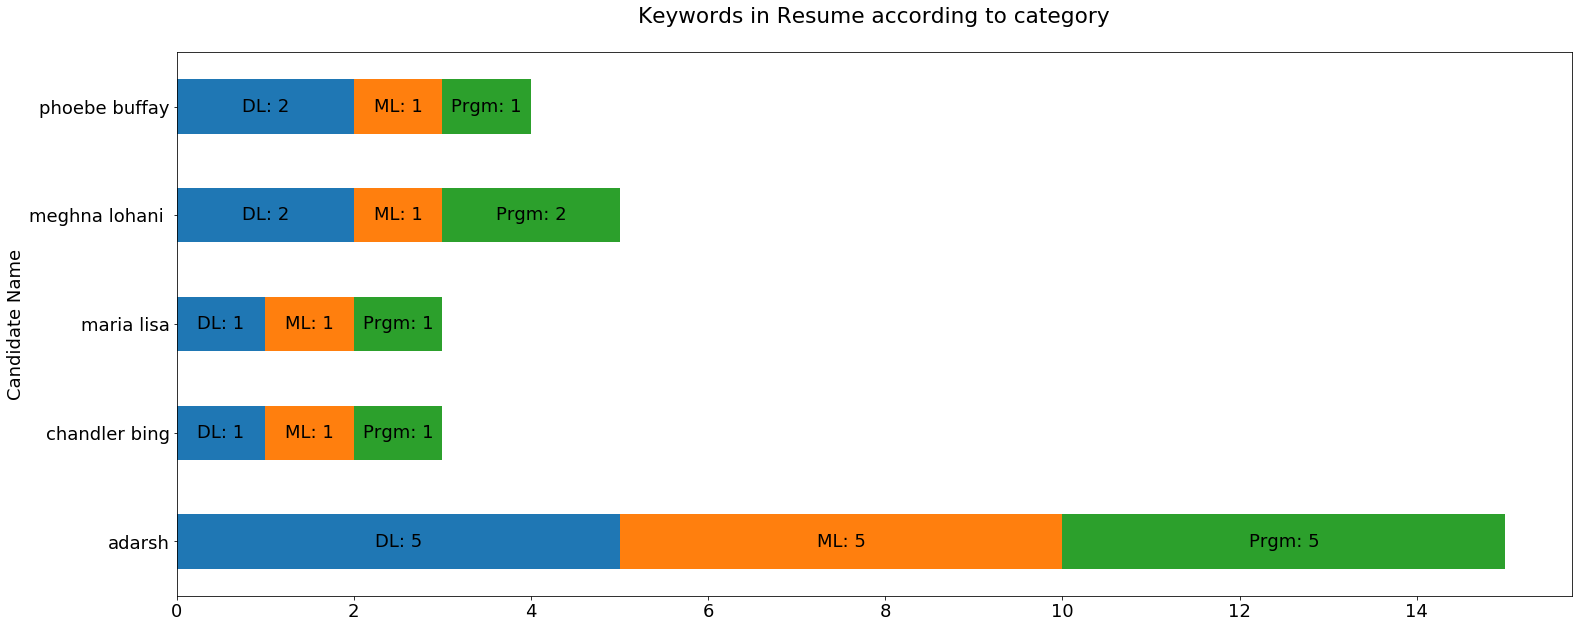

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})
ax = candidate_data.plot.barh(title="Keywords in Resume according to category\n", legend=False, figsize=(25,10), stacked=True)
skills = []
for j in candidate_data.columns:
    for i in candidate_data.index:
        skill = str(j)+": " + str(candidate_data.loc[i][j])
        skills.append(skill)
patches = ax.patches
for skill, rect in zip(skills, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., skill, ha='center', va='center')
plt.show()

### Calculating the percentage of match

In [18]:
res = []

files = []
# r=root, d=directories, f = files

name = []

path = 'C:\\Users\\Adarsh\\Documents\\ML\\resume-scoring\\Resumes\\'

for r,d,f in os.walk(path):
    for file in f:
        if '.pdf' in file:
            files.append(os.path.join(r, file))

for f in files:
    #print(f[52: -4]) 
    for k in range(1,6):
        name.append(f[52: -4])
        
names = []
names.append('')
names.append(name[1])
names.append(name[6])
names.append(name[11])
names.append(name[16])
names.append(name[21])
    
    
for k in range(1,6):
    r = parser.from_file("C:\\Users\\Adarsh\\Documents\\ML\\resume-scoring\\Resumes\\"+str(names[k])+".pdf")
    res.append(r['content'].strip())
    
for x in range(0,5):
    text = [res[x], job_description]
    count_matrix = cv.fit_transform(text)
    #get the match percentage
    matchPercentage = cosine_similarity(count_matrix)[0][1] * 100
    matchPercentage = round(matchPercentage, 3) # round to two decimal places
    print(names[x+1]+" - Your resume matches about "+ str(matchPercentage)+ "% of the job description.")


Adarsh - Your resume matches about 40.614% of the job description.
Chandler Bing - Your resume matches about 26.662% of the job description.
Maria Lisa - Your resume matches about 64.228% of the job description.
Meghna Lohani  - Your resume matches about 50.768% of the job description.
Phoebe Buffay - Your resume matches about 31.42% of the job description.


# References

1. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
2. https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/
3. https://app.sketchengine.eu/
